In [2]:
# Load library
import datetime
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pyplot as plt


# Load constants
DATA_PATH = "data/hand-sign-images"
TENSORBOARD_PATH = "tensorboard"

In [3]:
tf.__version__

'2.10.0'

# Checking Data

In [4]:
!tree /a

Folder PATH listing for volume Program and Files
Volume serial number is 081B-4D30
D:.
+---.ipynb_checkpoints
+---data
|   +---.ipynb_checkpoints
|   \---hand-sign-images
|       +---Test
|       |   +---A
|       |   +---B
|       |   +---C
|       |   +---D
|       |   +---E
|       |   +---F
|       |   +---G
|       |   +---H
|       |   +---I
|       |   +---K
|       |   +---L
|       |   +---M
|       |   +---N
|       |   +---O
|       |   +---P
|       |   +---Q
|       |   +---R
|       |   +---S
|       |   +---T
|       |   +---U
|       |   +---V
|       |   +---W
|       |   +---X
|       |   \---Y
|       \---Train
|           +---A
|           +---B
|           +---C
|           +---D
|           +---E
|           +---F
|           +---G
|           +---H
|           +---I
|           +---K
|           +---L
|           +---M
|           +---N
|           +---O
|           +---P
|           +---Q
|           +---R
|           +---S
|           +---T
|           +---U
| 

# Check available Model and its Specification

We're going to use https://tfhub.dev/emilutz/vgg19-block4-conv2-unpooling-encoder/1

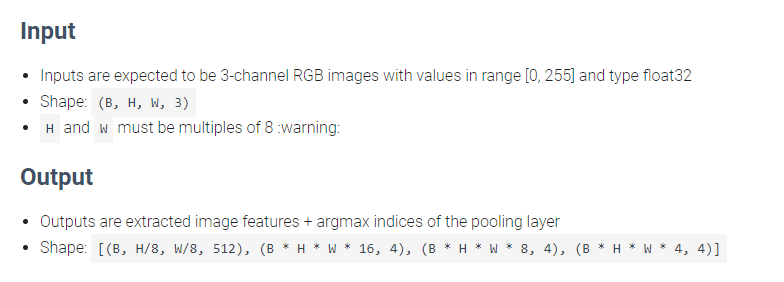  

Thus, we're going to process the data as the model spec

In [40]:
dataset_train = tf.keras.utils.image_dataset_from_directory(
    directory=f"{DATA_PATH}/Train",
    color_mode='rgb',
    label_mode='categorical',
    batch_size=32,
    image_size=(32, 32),
    seed=2023,
)
dataset_test = tf.keras.utils.image_dataset_from_directory(
    directory=f"{DATA_PATH}/Test",
    color_mode='rgb',
    label_mode='categorical',
    batch_size=32,
    image_size=(32, 32),
    seed=2023,
)

Found 27455 files belonging to 24 classes.
Found 7172 files belonging to 24 classes.


# Modelling!

In [41]:
test_encoder = hub.KerasLayer('https://tfhub.dev/emilutz/vgg19-block4-conv2-unpooling-encoder/1')

In [42]:
data_dummy = dataset_train.take(1)
data_dummy = list(data_dummy.as_numpy_iterator())
img = data_dummy[0][0]
print(img.shape)
[logits, b1_indices, b2_indices, b3_indices] = test_encoder(img)
logits.shape

(32, 32, 32, 3)


TensorShape([32, 4, 4, 512])

In [47]:
tf.keras.backend.clear_session()

def create_model():
    inputs = tf.keras.layers.Input((32,32,3), dtype=tf.float32)
    [x, _, _, _] = hub.KerasLayer('https://tfhub.dev/emilutz/vgg19-block4-conv2-unpooling-encoder/1', trainable=False)(inputs)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(24)(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
)

optim = tf.keras.optimizers.Adam(
    learning_rate=1e-4
)

model.compile(
    optimizer=optim,
    loss=loss,
    metrics=['accuracy']
)

In [48]:
model.fit(
    x=dataset_train,
    validation_data=dataset_test,
    epochs=4
)

Epoch 1/4
858/858 [==============================] - 81s 93ms/step - loss: 58.3899 - accuracy: 0.8857 - val_loss: 15.1948 - val_accuracy: 0.9501
Epoch 2/4
858/858 [==============================] - 81s 94ms/step - loss: 3.2570 - accuracy: 0.9811 - val_loss: 12.9713 - val_accuracy: 0.9499
Epoch 3/4
858/858 [==============================] - 84s 98ms/step - loss: 1.8344 - accuracy: 0.9903 - val_loss: 12.6440 - val_accuracy: 0.9576
Epoch 4/4
858/858 [==============================] - 81s 94ms/step - loss: 2.7822 - accuracy: 0.9883 - val_loss: 11.2645 - val_accuracy: 0.9685


In [49]:
model.fit(
    x=dataset_train,
    validation_data=dataset_test,
    epochs=2
)

Epoch 1/2
858/858 [==============================] - 80s 94ms/step - loss: 1.8956 - accuracy: 0.9925 - val_loss: 4.1215 - val_accuracy: 0.9833
Epoch 2/2
858/858 [==============================] - 80s 93ms/step - loss: 2.2964 - accuracy: 0.9925 - val_loss: 21.0171 - val_accuracy: 0.9640


In [52]:
model.save('handsign_model_transfer_learning_v1')

INFO:tensorflow:Assets written to: handsign_model_transfer_learning_v1\assets


INFO:tensorflow:Assets written to: handsign_model_transfer_learning_v1\assets


In [53]:
loaded_model = tf.keras.models.load_model('handsign_model_transfer_learning_v1')

In [55]:
loaded_model(img).shape

TensorShape([32, 24])